# Functional Data Analysis with Monovariate Prediction
This notebook demonstrates the process of conducting a functional data analysis with a focus on monovariate prediction. It outlines the goal of the notebook, the dataset being used, and the main steps that will be taken.

## 1. Setting Up the Environment
The following cells set up the environment by loading necessary libraries and defining the path to the simulation file.

In [2]:
# @__DIR__ is the directory of the current file
# We need to go up to the parent directory to find the project root
project_root = dirname(dirname(@__DIR__))


# include(joinpath(project_root, "setup", "init_env.jl"))
# set_R_lib_path(project_root)
using Plots
using Statistics
include(joinpath(project_root, "src", "simulation.jl"))


┌ Warning: RCall.jl: here() starts at C:/Users/User/Documents/repos/TESI/tesi_data/progetto_s_on_f.md/b_spline/functional-data-regression-mip
└ @ RCall C:\Users\User\.julia\packages\RCall\gOwEW\src\io.jl:172


load_simulation_gertheiss (generic function with 1 method)

## 2. Define simulation data
Here we load the data required for the simulation and run the R simulation script to prepare the data for analysis.

**NOTICE** -> The seed should be the same for both the training and the test datasets, otherwise the data distribution will be different. 
This is very important specifically in the "Paper simulation" where the predictors shape depends on the coefficients a1,...f3 extracted from Uniform and Normal distributions.  

In [97]:


simulation_name = "10_predictors"
simulation_settings_file = "default"

measurements = 100
observations = 100
basis_functions = 5
noise_snr = [1000,40]
base = 1.5# 2.5
coeff = 0
lambda = 10# base * 10.0^coeff


print(lambda)
params_train = (
    observations = observations,
    measurements = measurements,
    basis_functions = basis_functions,
    noise_snr = noise_snr,
    seed = 0
)

params_test = (
    observations = observations,
    measurements = measurements,
    basis_functions = basis_functions,
    noise_snr = noise_snr,
    seed = 100
)



10

(observations = 100, measurements = 100, basis_functions = 5, noise_snr = [1000, 40], seed = 100)

## 3. Run the simulation and save the data

In [98]:

# Note: Use ... to unpack NamedTuple into keyword arguments
output = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_train...)

output_test = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_test...)


# Grab the outputs from the R script

predictors = Int(output[:predictors])
true_predictors = output[:true_predictors]
intercept = output[:intercept]
observations = Int(output[:observations])

# betas and basis
beta_matrix  = output[:B]
basis_objs   = output[:basis_objs]
basis_values = output[:basis_values]
time_domains = output[:time_domains]

# matrixes 
U = output[:U]
X = output[:X]
Y = output[:Y]
Z = output[:Z]
J = output[:J]
W = output[:W]


X_test = output_test[:X]
Y_test = output_test[:Y]
Z_test = output_test[:Z]
J_test = output_test[:J]
W_test = output_test[:W]
beta_matrix_test  = output_test[:B]


[1] 100 NaN NaN
[1] "predictors: 10"
[1] "observations: 100"
[1] "measurements: 100"
[1] "basis_functions: 5"
[1] "intercept: 0"
[1] 1000   40
[1] 100 NaN NaN
[1] "predictors: 10"
[1] "observations: 100"
[1] "measurements: 100"
[1] "basis_functions: 5"
[1] "intercept: 0"
[1] 1000   40


10×5 Matrix{Float64}:
  1.45269   1.78361   2.2524    3.5948   4.00313
 -0.009356  0.376372  0.987209  1.81125  1.99947
  0.0       0.0       0.0       0.0      0.0
  0.0       0.0       0.0       0.0      0.0
  0.0       0.0       0.0       0.0      0.0
  0.0       0.0       0.0       0.0      0.0
  0.0       0.0       0.0       0.0      0.0
  0.0       0.0       0.0       0.0      0.0
  0.0       0.0       0.0       0.0      0.0
  0.999767  1.41805   2.41443   4.11502  5.31662

In [93]:
#between any observations, compute mean! carefull columns
(X[1,1,:])

300-element Vector{Float64}:
 -0.43165906753086725
 -0.41831435453430443
 -0.3992193889351089
 -0.35664502488917516
 -0.32000746884485765
 -0.27360655292798153
 -0.2457448009358599
 -0.23695891166638922
 -0.22161024484160313
 -0.20144428623309393
 -0.17245726712307077
 -0.14141541048572628
 -0.12002255324608857
  ⋮
  0.044263075017825344
  0.046591080067366245
  0.043502058243942945
  0.02174814575891197
 -0.009096032899029882
 -0.030549686994677416
 -0.023261666636062522
  0.0024755135311864684
  0.023506104636090208
  0.04956733747684147
  0.07864553342794484
  0.10322504245362568

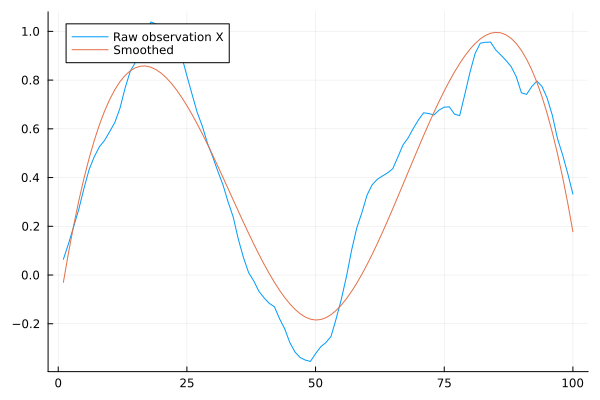

In [114]:
# plot first 10 observations of the first predictor 
p= 1

# #  plot(U[1,1,:], label="TRUE U", legend=:topleft)
# plot!(basis_values[1,:,:] * W[1, 1, :], label="W", legend=:topleft,color=:green)
plot()


# for i in 1:1
#     plot!(X[i, p, :], label="Observed X $i", color=:blue)
#     plot!(U[i, p, :], label="Observed X $i", color=:green)
#     plot!(basis_values[1,:,:] * W[i, p, :], label="W",  color=:red)


# end
#  plot(U[1,1,:], label="TRUE U", legend=:topleft)
pred = 10
plot(X[1,pred,:], label="Raw observation X", legend=:topleft)

plot!(basis_values[pred,:,:] * W[1, pred, :], label="Smoothed", legend=:topleft)


## 4. Model Execution
Run the predictive model using the prepared data.

In [115]:
model_name = "l0_and_l2" # l0_and_l2 gertheis
model_file_path_ = joinpath(project_root, "src", "Julia","ols_vs_mip_models", model_name *".jl")

include(model_file_path_)

beta_matrix_max_values = maximum(beta_matrix, dims = 2)
beta_matrix_min_values = minimum(beta_matrix, dims = 2)

# BigM = ones(predictors) .*     10000   # or use beta_matrix_max_values
# BigM_ =  ones(predictors) .*  - 10000  # or use beta_matrix_min_values
BigM = ones(size(beta_matrix)) .* 100  # or use beta_matrix_max_values
BigM_ = ones(size(beta_matrix)) .* -100  # or use beta_matrix_min_values

to_predict = sum(true_predictors)

# X is passed only for gertheis, Z otherwise
if model_name == "gertheis"
    Z_mat = X
else
    Z_mat = Z
end
initial_betas = zeros(size(beta_matrix))
beta_star, alpha_star, groups = 
#redirect_stdout(devnull) do
    mip_functional_regression(Y, Z_mat, BigM,BigM_; intercept = output[:intercept] != 0, group_limit= to_predict,lambda = 0.026367,initial_beta =initial_betas )#, initial_beta=beta_ols)
#end

#mip_functional_regression(Y, Z_mat, BigM,BigM_; intercept = output[:intercept] != 0, group_limit= to_predict,lambda = 244.444,initial_beta =beta_matrix )#, initial_beta=beta_ols)





Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Set parameter TimeLimit to value 100
Set parameter Heuristics to value 1
Set parameter MIPGap to value 0.01
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 2
Set parameter NonConvex to value 2
Set parameter OptimalityTol to value 1e-09
Set parameter IntFeasTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter LPWarmStart to value 2


LoadError: Unrecognized function "avg" used in nonlinear expression.

You must register it as a user-defined function before building
the model. For example, replacing `N` with the appropriate number
of arguments, do:
```julia
model = Model()
register(model, :avg, N, avg, autodiff=true)
# ... variables and constraints ...
```


COLLAZOS -> GERT

0.251315     0.279239     0.335087     0.418859     0.474706     0.50263
  0.453117     0.503463     0.604156     0.755194     0.855887     0.906233
  0.0          0.0          0.0          0.0          0.0          0.0
  0.529864     0.588737     0.706485     0.883106     1.00085      1.05973
  0.0          0.0          0.0          0.0          0.0          0.0
 -0.00135389  -0.00150432  -0.00180519  -0.00225649  -0.00255735  -0.00270778

### 5. OLS SOLUTION COMPUTATION 
I needed to reshape the matrixes because of the rappresention that I am using

In [76]:
function ols_solution(Y, Z)
    # Y: Vector of observed response variables
    # Z: Matrix of predictor variables
    
    _i, _j, _k = size(Z)

    # Permute dimensions so that Z becomes the second dimension
    Z_permuted = permutedims(Z, [1, 3, 2])

    # Reshape the permuted array into a 2D matrix
    Z_reshaped = reshape(Z_permuted, _i, _j * _k)

    beta = (Z_reshaped \ Y)
    beta_out = zeros(_j, _k)
    # create a matrix where each row is basis-function coefficients for a predictor
    # without breaking the order of the coefficients
    for i in 1: _j 
        for j in 1: _k
            beta_out[i, j] = beta[(i - 1) * _k + j]
        end
    end

    return beta_out
end
beta_ols= ols_solution(Y, Z)

10×10 Matrix{Float64}:
 -0.878811   5.36156  -1.98484    5.26563    …   4.98743    3.01208   4.23879
  0.150182   4.41905  -4.9235     4.63813        4.58214   -1.89477   6.9992
 -0.38969    1.85999  -2.72086    2.07102       -0.876524  -1.70039   4.56599
  1.06904   -1.43774   0.137063  -0.210859       1.32882   -1.18004   1.35771
  5.55956   -5.69327   5.43659   -5.67469       -7.61207    9.09575  -7.78687
 -5.15979    4.43192  -0.447286  -0.661853   …  -2.60357    2.5718   -1.34337
 -6.6002     8.79341  -8.62137    5.46593       -0.21836    3.75361  -7.42444
  4.97749   -4.57452   1.24467    0.0617475      3.21774   -5.38052   5.5427
  2.65007   -3.41268   2.6087    -1.22697        5.09314   -6.42682   5.51825
  1.21904   -1.5068    3.89945    0.825039       9.32807   -5.16258  17.868

## 6. Comparing Model Results
Display the results of the model, including the estimated beta coefficients.

In [87]:
beta_matrix # true beta

10×10 Matrix{Float64}:
 1.47218      1.54317    1.7055    …  3.11906  3.54672  4.09538  3.82584
 0.000330982  0.0988666  0.300643     1.50682  1.76995  2.05022  1.9107
 0.0          0.0        0.0          0.0      0.0      0.0      0.0
 0.0          0.0        0.0          0.0      0.0      0.0      0.0
 0.0          0.0        0.0          0.0      0.0      0.0      0.0
 0.0          0.0        0.0       …  0.0      0.0      0.0      0.0
 0.0          0.0        0.0          0.0      0.0      0.0      0.0
 0.0          0.0        0.0          0.0      0.0      0.0      0.0
 0.0          0.0        0.0          0.0      0.0      0.0      0.0
 1.0          1.119      1.37127      3.54845  4.34343  4.97261  5.31767

In [88]:
beta_star  # estimated beta

10×10 Matrix{Float64}:
  0.872612   1.74783    1.4756      2.42217   …   3.67539   4.07034   2.46326
  0.502964   0.54953    0.0148436   0.652828      1.93096   2.15954   1.58309
 -0.0       -0.0       -0.0        -0.0          -0.0      -0.0      -0.0
 -0.0       -0.0       -0.0        -0.0          -0.0      -0.0      -0.0
  0.0        0.0        0.0         0.0           0.0       0.0       0.0
  0.0        0.0        0.0         0.0       …   0.0       0.0       0.0
 -0.0       -0.0       -0.0        -0.0          -0.0      -0.0      -0.0
  0.0        0.0        0.0         0.0           0.0       0.0       0.0
  0.0        0.0        0.0         0.0           0.0       0.0       0.0
  0.6229     0.861338   1.52739     1.76454       4.14193   5.33023   4.09469

In [ ]:
beta_ols  # ols beta

In [33]:
groups

10-element Vector{Float64}:
 -0.0
 -0.0
  1.0
  0.0
  1.0
 -0.0
 -0.0
 -0.0
 -0.0
  1.0

In [ ]:
alpha_star

## Visualize solutions
Plot the combined predicted curve and save the output for further analysis.

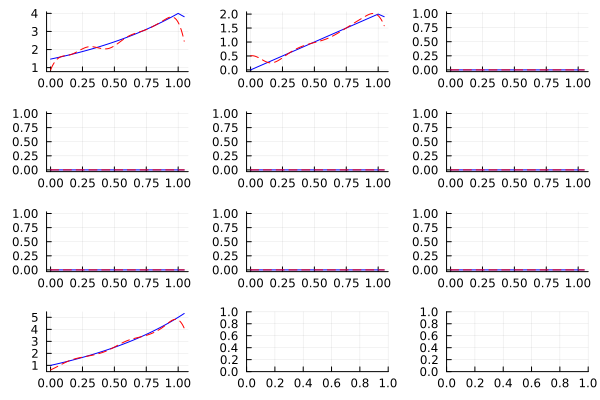

"c:\\Users\\User\\Documents\\repos\\TESI\\tesi_data\\progetto_s_on_f.md\\b_spline\\functional-data-regression-mip\\outputs\\plots\\10_predictors\\combined.png"

In [89]:
project_root = dirname( dirname(@__DIR__))
plot_file_path = joinpath(project_root, "src", "Julia","utils", "plot.jl")

include(plot_file_path)

output_folder= joinpath(project_root, "outputs", "plots", simulation_name)

beta_point_values = output_test[:beta_point_values]
# plot_combined_predicted_curve(beta_point_values, beta_star,basis_values, time_domains,output_folder, true; upper_bound = UB_M, lower_bound = LB_M)
plot_combined_predicted_curve(beta_point_values, beta_star,basis_values, time_domains,output_folder, true)



In [ ]:
project_root = dirname( dirname(@__DIR__))
plot_file_path = joinpath(project_root, "src", "Julia","utils", "plot.jl")

include(plot_file_path)

output_folder= joinpath(project_root, "outputs", "plots", simulation_name)

beta_point_values = output_test[:beta_point_values]
# plot_combined_predicted_curve(beta_point_values, beta_star,basis_values, time_domains,output_folder, true; upper_bound = UB_M, lower_bound = LB_M)
plot_combined_predicted_curve(beta_point_values, beta_ols,basis_values, time_domains,output_folder, true)



In [ ]:

using Statistics 
using LinearAlgebra

include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

performance_metrics = compute_metrics(Y_test, Z_test, beta_matrix_test, beta_matrix, alpha_star, groups, predictors,basis_values)


In [83]:

using Statistics 
using LinearAlgebra
using JSON
include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

performance_metrics = compute_metrics(Y_test, Z_test, beta_matrix_test, beta_star, alpha_star, groups, predictors, basis_values )
JSON.print(performance_metrics)
println(" ")
print(performance_metrics["SE_Coefficients"])
performance_metrics

{"CDF_Distance":0.561733676576404,"RMSE_Predictions":0.2994747216960187,"RMSE_Coefficients":0.31937015333423235,"Area_Between_Curves":71.8738508736513,"ISE_Coefficients":65.77127499257693,"Adjusted_R_squared":0.9160129616054216,"SE_Coefficients":[5.74664802049607,4.228729271897332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.8555363136798744],"R_squared":0.9188218631786971,"IQR":3.193701533342323,"MSE_Predictions":0.08968510893490783,"MSE_Coefficients":0.1019972948407311} 
[5.74664802049607, 4.228729271897332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.8555363136798744]

Dict{String, Any} with 11 entries:
  "CDF_Distance"        => 0.561734
  "RMSE_Predictions"    => 0.299475
  "RMSE_Coefficients"   => 0.31937
  "Area_Between_Curves" => 71.8739
  "ISE_Coefficients"    => 65.7713
  "Adjusted_R_squared"  => 0.916013
  "SE_Coefficients"     => [5.74665, 4.22873, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0…
  "R_squared"           => 0.918822
  "IQR"                 => 3.1937
  "MSE_Predictions"     => 0.0896851
  "MSE_Coefficients"    => 0.101997

In [ ]:

using Statistics 
using LinearAlgebra

include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

performance_metrics = compute_metrics(Y_test, Z_test, beta_matrix_test, beta_ols, alpha_star, groups, predictors, basis_values)
json = JSON.print(performance_metrics)

## Residual Analysis
Analyze the residuals from the model to check for any patterns that might suggest issues with the model.

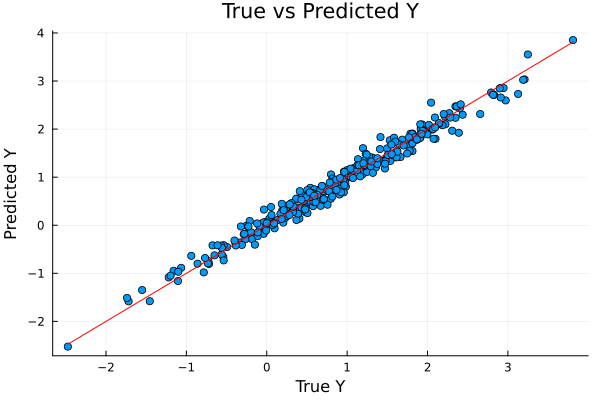

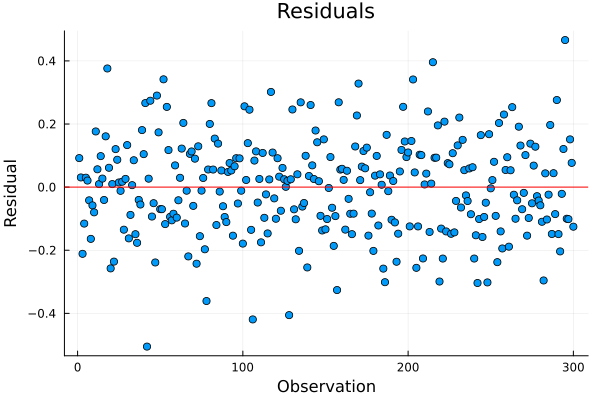

In [90]:
using Plots

Y_pred = get_predictions(Z_test, beta_star, alpha_star)
# 1. Scatter plot comparing true vs predicted values
scatter(Y_test, Y_pred, xlabel="True Y", ylabel="Predicted Y", legend=false, title="True vs Predicted Y")
plot!(Y_test, Y_test, color=:red)  # A y=x line for reference
display(plot!())

# 2. Plot residuals
residuals = Y_test - Y_pred
scatter(1:observations, residuals, xlabel="Observation", ylabel="Residual", legend=false, title="Residuals")
hline!([0], color=:red, label="Zero line")
display(plot!())


In [ ]:
pbasis_values =basis_values
plot(pbasis_values[1,:,1])
for i in 1:basis_functions
    plot!(pbasis_values[1,:,i])
end

plot!(pbasis_values[1,:,basis_functions])


## Hypothesis Testing in Functional Data Regression
Hypothesis testing in FDA is crucial for several reasons:
- **Understanding Individual Predictors**: It allows researchers to understand the influence of individual functional predictors on a scalar response, which is key in many applications like growth curves, weather patterns, and more.
- **Model Simplification**: By testing the significance of each predictor, it's possible to simplify the model by removing non-significant predictors, leading to more interpretable and efficient models.
- **Statistical Rigor**: Hypothesis testing adds a layer of statistical rigor, enabling researchers to make informed decisions about the inclusion or exclusion of predictors based on statistical evidence rather than intuition or heuristics.
- 
## Conceptual Framework of Testing in FRM:
Testing individual functional predictors in a Functional Regression Model (FRM) is aimed at assessing their significance in predicting a scalar response. The typical null hypothesis \( H_0: b_r = 0 \) against the alternative \( H_a: b_r \neq 0 \) is a fundamental aspect of this process. This hypothesis testing framework is critical to distinguish predictors that have a meaningful impact on the response from those that do not.


- **Assumptions for Estimator Uniqueness**: A critical assumption in FRM is that the matrix \(Z\) should have fewer linearly independent columns than the number of observations (\(k < n\)). This ensures the existence and uniqueness of the least squares estimators, which is fundamental for the reliability of the regression model.
- **Residual Sum of Squares (RSS)**: RSS measures the discrepancy between the observed scalar responses and the responses predicted by the model. It is calculated as the sum of the squares of the residuals (the differences between observed and predicted values).

- **\(RSS_0\)**: This represents the Residual Sum of Squares for a reduced model where a particular functional predictor (and all its associated B-Spline coefficients) is excluded. Comparing \(RSS\) and \(RSS_0\) allows for testing the significance of the excluded predictor.

  ### Understanding the Distribution of the Test Statistic \( TL \)

#### The Chi-Square Distribution of \( TL \)

The test statistic \( TL \) in our hypothesis testing framework is crucial for determining the significance of each functional predictor in the model. Under certain assumptions, \( TL \) follows a chi-square distribution, specifically \( \chi^2_{k - k_0}(\delta) \). Here, \( k - k_0 \) are the degrees of freedom, and \( \delta \) is the non-centrality parameter. This distribution is pivotal for interpreting the test results accurately and for calculating the p-values, which are essential in statistical hypothesis testing.

#### Determining Key Quantities: \( K \), \( N \), and Degrees of Freedom

- **Role of \( K \) (Number of Coefficients)**: 
  - In our functional regression model, \( K \) represents the total number of coefficients. This includes all the coefficients associated with the B-Spline basis functions for our functional predictors. It's the dimensionality of our model, reflecting the complexity introduced by the predictors.

- **Role of \( N \) (Number of Observations)**: 
  - \( N \) signifies the total number of observations in our dataset. Each observation corresponds to a set comprising a functional predictor and its associated scalar response. The size of \( N \) is a key factor in determining the model's ability to estimate the parameters accurately and in assessing the statistical power of our tests.

- **Calculating Degrees of Freedom (DF)**:
  - Degrees of freedom, denoted as \( k - k_0 \), are calculated based on the difference in the number of estimated parameters under the full model (with all predictors) and the reduced model (under the null hypothesis, excluding specific predictors). This concept is central to understanding the distribution of \( TL \) and therefore to assessing the significance of each predictor in our model.

#### Using the Chi-Square Distribution for Statistical Inference

Understanding the chi-square distribution of \( TL \) allows us to derive p-values from our test statistics. These p-values are the probabilities of observing a test statistic as extreme as, or more extreme than, what we have observed, under the assumption that the null hypothesis is true. They are a cornerstone in making decisions about the statistical significance of our predictors. A low p-value (typically less than 0.05) suggests that the predictor has a significant impact on the response variable.

To derive these p-values, we compare the calculated \( TL \) statistic for each predictor against the chi-square distribution with \( k - k_0 \) degrees of freedom. This comparison will yield the probability (p-value) of obtaining a test statistic as extreme as the observed one under the null hypothesis.
To calculate \( N \), \( K \), and the degrees of freedom (DF):

1. **\( N \) (Number of Observations)**:
   - \( N \) is simply the sample size of our observations. Since we have direct access to the `observations` variable, \( N \) is equal to the size of this variable.

2. **\( K \) (Total Number of Coefficients in the Model)**:
   - To compute \( K \), we need to consider the number of basis functions used for each functional predictor and the total number of predictors.
   - If each of the `predictors` uses the same number of basis functions (denoted by `basis_functions`), then \( K \) can be calculated as the product of the number of predictors and the number of basis functions for each predictor.
   - However, if the number of basis functions varies across predictors, we would need to sum the number of basis functions for each predictor individually.

3. **\( k_0 \)** is the total number of coefficients in the model excluding the coefficients corresponding to the predictor being testedunder the null hypothesis \( H_0 \) of that specific predictor. 
   - If each predictor contributes an equal number of coefficients (say, every predictor uses the same number of basis functions), then \( k_0 \) remains constant across different null hypotheses, each testing a different predictor.
   - If the number of coefficients varies per predictor, \( k_0 \) will differ depending on which predictor's effect is being zeroed out in \( Z \).
1. **Degrees of Freedom (DF)**:
   - DF for the test statistic is calculated as \( k - k_0 \).

In [ ]:
function hypothesis_test_old(Y, Z, lambda, predictors, intercept, group_limit,BigM,BigM_)
    test_stats = Dict()
    to_predict = sum(true_predictors)
    
    for r in 1:length(predictors)
        # Fit model under H0 (excluding the r-th predictor)
        Z_H0 = copy(Z)
        Z_H0[:, r, :] .= 0  # Set the r-th predictor coefficients to 0


        beta_star_H0, alpha_star_H0, _ =mip_functional_regression(Y, Z_H0, BigM,BigM_; intercept = output[:intercept] != 0, group_limit= to_predict, lambda = lambda)

        # Compute predictions and RSS0
        predictions_H0 = get_predictions(Z_H0, beta_star_H0, alpha_star_H0)
        RSS0 = sum((Y - predictions_H0).^2)

        # Fit model under Ha (including all predictors)
        beta_star_Ha, alpha_star_Ha, _ = mip_functional_regression(Y, Z, BigM,BigM_; intercept = output[:intercept] != 0, group_limit= to_predict,lambda = lambda)
        # Compute predictions and RSS
        predictions_Ha = get_predictions(Z, beta_star_Ha, alpha_star_Ha)
        RSS = sum((Y - predictions_Ha).^2)
        # print(RSS,"__", RSS0)
        # Compute test statistic
        TL = (RSS0 - RSS) / var(Y)  # Assuming var(Y) as an estimate for σ²
        test_stats[r] = abs(TL)
    end

    test_stats
end

In [ ]:
include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))


include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

function hypothesis_test(Y, Z, lambda, predictors, intercept, group_limit, BigM, BigM_)
    test_stats = Dict()
    to_predict = sum(true_predictors)
    
    # Fit the full model once
    beta_star_Ha, alpha_star_Ha, _ = mip_functional_regression(Y, Z, BigM, BigM_;
                                                               intercept = output[:intercept] != 0,
                                                               group_limit = to_predict,
                                                               lambda = lambda)
    
    for r in 1:length(predictors)
        # Fit model under H0 (excluding the r-th predictor)
        Z_H0 = copy(Z)
        Z_H0[:, r, :] .= 0  # Set the r-th predictor coefficients to 0

        # Fit the model under H0
        beta_star_H0, alpha_star_H0, _ = mip_functional_regression(Y, Z_H0, BigM, BigM_;
                                                                   intercept = output[:intercept] != 0,
                                                                   group_limit = to_predict,
                                                                   lambda = lambda)

        # Compute residual sum of squares under H0 and Ha
        RSS0 = sum((Y - get_predictions(Z_H0, beta_star_H0, alpha_star_H0)).^2)
        RSS = sum((Y - get_predictions(Z, beta_star_Ha, alpha_star_Ha)).^2)

        # Compute test statistic according to the provided formula
        δ = dot(beta_star_Ha, Z' * (projection_matrix(Z) - projection_matrix(Z_H0)) * Z * beta_star_Ha) / σ^2
        test_stat = (RSS0 - RSS) / σ^2 / (n - k0)
        
        # Store the test statistic for the r-th predictor
        test_stats[r] = test_stat
    end

    test_stats
end


function compute_p_values(test_stats, df)
    p_values = Dict()
    
    for (predictor, TL) in test_stats
        # Calculate the p-value
        out = cdf(Chisq(df), TL)
        p_value = 1 - out
        p_values[predictor] = p_value
    end
    
    p_values
end
# Apply Bonferroni correction
function apply_bonferroni_correction(p_values, M)
    corrected_p_values = Dict()
    for (predictor, p_value) in p_values
        corrected_p_value = min(p_value * M, 1.0)  # Ensuring that p-values don't exceed 1
        corrected_p_values[predictor] = corrected_p_value
    end
    
    corrected_p_values
end

function apply_fdr_correction(p_values, M)
    sorted_indices = sortperm(collect(p_values), by=x->x[2])
    adjusted_p_values = copy(p_values)
    
    # Start from the largest p-value, moving towards the smallest
    min_pval = 1.0
    for i in reverse(1:M)
        idx = sorted_indices[i]
        adjusted_p_value = min(p_values[idx] * M / i, min_pval)
        adjusted_p_values[idx] = adjusted_p_value
        min_pval = adjusted_p_value  # Ensure non-decreasing adjusted p-values
    end
    
   
    return adjusted_p_values
end

using Statistics
using Distributions

function monte_carlo_simulation( TOTAL_runs ,observations, measurements, basis_functions, noise_snr, lambda,simulation_name,simulation_settings_file,model_name)
    _correct_models_bonf = Dict(
        "0.01" => 0,
        "0.05" => 0,
        "0.1" => 0
    )
    
    _correct_models_fdr = Dict(
        "0.01" => 0,
        "0.05" => 0,
        "0.1" => 0
    )
    _correct_models_mip = 0
    

    _AMSE = 0.0
    for i in 1:TOTAL_runs

        # measurements = 50
        # observations = 100
        # basis_functions = 6
        noise_snr = [60,60]
        # base = 1.5# 2.5
        # coeff = 0
        # lambda = 0.1# base * 10.0^coeff
        # print(lambda)
        params_train = (
            observations = observations,
            measurements = measurements,
            basis_functions = basis_functions,
            noise_snr = noise_snr,
            seed = i
        )
        
        params_test = (
            observations = observations ,
            measurements = measurements,
            basis_functions = basis_functions,
            noise_snr = noise_snr,
            seed = i*2
        )
        

        # Note: Use ... to unpack NamedTuple into keyword arguments
        output = load_simulation_data(simulation_name, simulation_settings_file, project_root;      params_train...)

        output_test = load_simulation_data(simulation_name, simulation_settings_file, project_root;         params_test...)


        # Grab the outputs from the R script

        predictors = Int(output[:predictors])
        true_predictors = output[:true_predictors]
        intercept = output[:intercept]
        observations = Int(output[:observations])

        # betas and basis
        beta_matrix  = output[:B]
        basis_objs   = output[:basis_objs]
        basis_values = output[:basis_values]
        time_domains = output[:time_domains]

        # matrixes 
        U = output[:U]
        X = output[:X]
        Y = output[:Y]
        Z = output[:Z]
        J = output[:J]
        W = output[:W]


        X_test = output_test[:X]
        Y_test = output_test[:Y]
        Z_test = output_test[:Z]
        J_test = output_test[:J]
        W_test = output_test[:W]
        beta_matrix_test  = output_test[:B]




        model_file_path = joinpath(project_root, "src", "Julia","ols_vs_mip_models", model_name *".jl")
        include(model_file_path)
        beta_matrix_max_values = maximum(beta_matrix, dims = 2)
        beta_matrix_min_values = minimum(beta_matrix, dims = 2)
        print("beta_matrix_max_values",size(beta_matrix))

        # BigM = ones(predictors) .*     10000   # or use beta_matrix_max_values
        # BigM_ =  ones(predictors) .*  - 10000  # or use beta_matrix_min_values
        BigM = ones(size(beta_matrix)) .*     100000   # or use beta_matrix_max_values
        BigM_ =  ones(size(beta_matrix)) .*  - 100000  # or use beta_matrix_min_values

        to_predict = sum(true_predictors)

        
        beta_star, alpha_star, groups = mip_functional_regression(Y, Z, BigM,BigM_; intercept = output[:intercept] != 0, group_limit= to_predict,lambda = lambda)

        #
        
        performance_metrics = compute_metrics(Y_test, Z_test, beta_matrix_test, beta_star, alpha_star, groups, predictors,basis_values)
        _AMSE = _AMSE + performance_metrics["MSE_Predictions"]

        # Call the function
        vectorized_predictors = collect(1:predictors)
        test_results = hypothesis_test(Y, Z, lambda, vectorized_predictors, intercept != 0, to_predict,BigM,BigM_)
        # 
        basis_functions = output[:basis_functions]
        N = observations  
        K = predictors * basis_functions
        K_0 = K - basis_functions
        DF = K - K_0 

        # Calculate p-values
        p_values = compute_p_values(test_results, DF)  # Use k0_values dictionary

        # Apply Bonferroni correction
        bonferroni_corrected_p_values = apply_bonferroni_correction(p_values, length(predictors))


        
        fdr_corrected_p_values = apply_fdr_correction(p_values, length(predictors))

        # Define significance level
        alpha = 0.05
        q = 0.005


        # count how many element in  groups match  to_predict vectorize
        count = 0
        for i in 1:predictors
            if true_predictors[i] == groups[i] 
                count += 1
            end
        end
        if(count == predictors)
            _correct_models_mip += 1
        end


        test_values = [0.01, 0.05, 0.1]
        for _a in test_values
            # Identify significant predictors
            significant_predictors_bonferroni = [key for (key, p_value) in fdr_corrected_p_values if p_value <= _a]
            significant_predictors_fdr = [predictor for (predictor, p_value) in bonferroni_corrected_p_values       if p_value < _a]
            # if all elements in significant predicotr are index on groups, and the value is 1, then the group is correctly identified by this model 
            # write the code
            println("Significant predictors: ",_a)
            println(significant_predictors_bonferroni)
            println(significant_predictors_fdr)
            println(true_predictors)
            println(groups)

            counter = 0
            for i in significant_predictors_bonferroni

                counter += true_predictors[i] 
            end
            # print(counter == to_predict ? "The model correctly identified all groups" : "The model did not correctly identify all groups")
            # println(counter == to_predict)
            if(counter == to_predict)
                _correct_models_bonf[string(_a)] += 1
            end

            counter = 0
            for i in significant_predictors_fdr
                counter += true_predictors[i]
            end
            # print(counter == to_predict ? "The model correctly identified all groups" : "The model did not correctly identify all groups")
            # println(counter == to_predict)
            if(counter == to_predict)
                _correct_models_fdr[string(_a)] += 1
            end
        end

    end
    out_mse = _AMSE/TOTAL_runs
    println(_correct_models_bonf)
    println(_correct_models_fdr)
    println(_correct_models_mip)
    println(out_mse)
    return _correct_models_bonf, _correct_models_fdr,_correct_models_mip, out_mse
end





In [3]:
function hypothesis_test(Y, Z, lambda, predictors, intercept, group_limit, BigM, BigM_)
    test_stats = Dict()
    to_predict = sum(true_predictors)
    
    # Fit the full model once
    beta_star_Ha, alpha_star_Ha, _ = mip_functional_regression(Y, Z, BigM, BigM_;
                                                               intercept = output[:intercept] != 0,
                                                               group_limit = to_predict,
                                                               lambda = lambda)
    
    for r in 1:length(predictors)
        # Fit model under H0 (excluding the r-th predictor)
        Z_H0 = copy(Z)
        Z_H0[:, r, :] .= 0  # Set the r-th predictor coefficients to 0

        # Fit the model under H0
        beta_star_H0, alpha_star_H0, _ = mip_functional_regression(Y, Z_H0, BigM, BigM_;
                                                                   intercept = output[:intercept] != 0,
                                                                   group_limit = to_predict,
                                                                   lambda = lambda)

        # Compute residual sum of squares under H0 and Ha
        RSS0 = sum((Y - get_predictions(Z_H0, beta_star_H0, alpha_star_H0)).^2)
        RSS = sum((Y - get_predictions(Z, beta_star_Ha, alpha_star_Ha)).^2)
        
        # Compute non-centrality parameter δ
        # delta_num = sum(beta_star_Ha .* (Z * beta_star_Ha))
        # delta_denom = sum(beta_star_H0 .* (Z * beta_star_H0))
        # δ = (delta_num - delta_denom) / σ^2

        # Compute test statistic according to the provided formula
        test_stat = (RSS0 - RSS) /  var(Y)  
        
        # Store the test statistic for the r-th predictor
        test_stats[r] = test_stat
    end

    test_stats
end


hypothesis_test (generic function with 1 method)

In [ ]:
let
   
    model_name = "l0_and_l2"
    model_file_path = joinpath(project_root, "src", "Julia", "ols_vs_mip_models", model_name * ".jl")
    include(model_file_path)
    

    simulation_name = "10_predictors"
    simulation_settings_file = "default"

    montecarlo_N = 1
    measurements = 300
    observations = 300
    basis_functions = 10
    noise_snr = [100,10]
    lambda =0.1

    global out, amse
    
    out, out2, cmip, amse =# redirect_stdout(devnull) do
         monte_carlo_simulation(montecarlo_N, observations, measurements, basis_functions, noise_snr, lambda, simulation_name, simulation_settings_file,model_name)
    #end 
    # Print the value of amse
    println(amse)
    println(out)
    println(out2)
    println(cmip)

end;

In [ ]:
let
    simulation_name = "paper"
    model_name = "l0_and_l2" #l0_and_l2
    simulation_settings_file = "default"
    montecarlo_N = 1
    measurements = 50
    observations = 100
    basis_functions = 6
    noise_snr = [100,100]
    lambda =0.1

    global out, amse
    
    out, out2, cmip, amse =# redirect_stdout(devnull) do
         monte_carlo_simulation(montecarlo_N, observations, measurements, basis_functions, noise_snr, lambda, simulation_name, simulation_settings_file,model_name)
    #end 
    # Print the value of amse
    println(amse)
    println(out)
    println(out2)
    println(cmip)

end;




# let
#     simulation_name = "paper"
#     model_name = "l0_and_l2"
#     simulation_settings_file = "c_04"
#     montecarlo_N = 20
#     measurements = 50
#     observations = 300
#     basis_functions = 6
#     noise_snr = [100,100]
#     lambda =0.1

#     global out, amse
    
#     out, out2, cmip, amse = redirect_stdout(devnull) do
#          monte_carlo_simulation(montecarlo_N, observations, measurements, basis_functions, noise_snr, lambda, simulation_name, simulation_settings_file,model_name)
#     end 
#     # Print the value of amse
#     println(amse)
#     println(out)
#     println(out2)
#     println(cmip)

# end;

# # let
# #     simulation_name = "paper"
# #     model_name = "l0_and_l2"
# #     simulation_settings_file = "c_08"
# #     montecarlo_N = 20
# #     measurements = 50
# #     observations = 100
# #     basis_functions = 6
# #     noise_snr = [100,100]
# #     lambda =0.1

# #     global out, amse
    
# #     out, out2, cmip, amse = redirect_stdout(devnull) do
# #          monte_carlo_simulation(montecarlo_N, observations, measurements, basis_functions, noise_snr, lambda, simulation_name, simulation_settings_file,model_name)
# #     end 
# #     # Print the value of amse
# #     println(amse)
# #     println(out)
# #     println(out2)
# #     println(cmip)

# # end;



# # let
# #     simulation_name = "paper"
# #     model_name = "l0_and_l2"
# #     simulation_settings_file = "c_08"
# #     montecarlo_N = 20
# #     measurements = 50
# #     observations = 300
# #     basis_functions = 6
# #     noise_snr = [100,100]
# #     lambda =0.1

# #     global out, amse
    
# #     out, out2, cmip, amse = redirect_stdout(devnull) do
# #          monte_carlo_simulation(montecarlo_N, observations, measurements, basis_functions, noise_snr, lambda, simulation_name, simulation_settings_file,model_name)
# #     end 
# #     # Print the value of amse
# #     println(amse)
# #     println(out)
# #     println(out2)
# #     println(cmip)

# # end;








In [4]:
using Random
include(joinpath(project_root, "src", "simulation.jl"))

function run_lambda_test_grid(k_fold,observations, measurements, basis_functions, noise_snr, lambda,simulation_name,simulation_settings_file,lambda_values_to_test)



    params_train = (
        observations=observations,
        measurements=measurements,
        basis_functions=basis_functions,
        noise_snr=noise_snr,
        seed=0
    )

    params_test = (
        observations=observations,
        measurements=measurements,
        basis_functions=basis_functions,
        noise_snr=noise_snr,
        seed=100
    )



    # Note: Use ... to unpack NamedTuple into keyword arguments
    output = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_train...)

    output_test = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_test...)


    # Grab the outputs from the R script

    predictors = Int(output[:predictors])
    true_predictors = output[:true_predictors]
    intercept = output[:intercept]
    observations = Int(output[:observations])

    # betas and basis
    beta_matrix = output[:B]
    basis_objs = output[:basis_objs]
    basis_values = output[:basis_values]
    time_domains = output[:time_domains]

    # matrixes 
    U = output[:U]
    X = output[:X]
    Y = output[:Y]
    Z = output[:Z]
    J = output[:J]
    W = output[:W]


    X_test = output_test[:X]
    Y_test = output_test[:Y]
    Z_test = output_test[:Z]
    J_test = output_test[:J]
    W_test = output_test[:W]
    beta_matrix_test = output_test[:B]

    beta_matrix_max_values = maximum(beta_matrix, dims=2)
    beta_matrix_min_values = minimum(beta_matrix, dims=2)

    BigM = ones(size(beta_matrix)) .* 100000   # or use beta_matrix_max_values
    BigM_ = ones(size(beta_matrix)) .* -100000  # or use beta_matrix_min_values

    to_predict = sum(true_predictors)
    metrics = Dict()

    # Split data into k folds
    indices = collect(1:length(Y))
    Random.shuffle!(indices)
    folds = collect(Iterators.partition(indices, div(length(Y), k_fold)))

    avg_mse_per_lambda = Dict{Float64,Float64}()
    avg_ise_per_lambda = Dict{Float64,Float64}()

    for lambda in lambda_values_to_test
        println("lambda: ", lambda)
        fold_metrics = []
        fold_mse = []
        fold_ise = []
        for fold in 1:k_fold
            # Use fold for validation, rest for training
            validation_indices = folds[fold]
            train_indices = setdiff(indices, validation_indices)

            Y_train, Z_train = Y[train_indices], Z[train_indices, :, :]
            Y_val, Z_val = Y[validation_indices], Z[validation_indices, :, :]

            beta_star, alpha_star, groups = mip_functional_regression(Y_train, Z_train, BigM, BigM_;
                intercept=output[:intercept] != 0,
                group_limit=to_predict,
                lambda=lambda)

            performance_metrics = compute_metrics(Y_val, Z_val, beta_matrix_test, beta_star, alpha_star, groups, predictors,basis_values)
            push!(fold_metrics, performance_metrics)
            push!(fold_ise, performance_metrics["ISE_Coefficients"])  # Assuming compute_metrics returns a dictionary with "MSE"

            push!(fold_mse, performance_metrics["MSE_Predictions"])  # Assuming compute_metrics returns a dictionary with "MSE"
        end
        # average the metrics over the folds that is an array of Dictioranies
        avg_metrics = Dict()
        for i in 1:length(fold_metrics)
            for (key, value) in fold_metrics[i]
                if haskey(avg_metrics, key)
                    avg_metrics[key] += value
                else
                    avg_metrics[key] = value
                end
            end
        end        
        # now put average values in the dictionary
        for (key, value) in avg_metrics
            avg_metrics[key] = value / length(fold_metrics)
        end
        metrics[lambda] = [avg_metrics]

        avg_mse = mean(fold_mse)
        avg_ise = mean(fold_ise)

        avg_mse_per_lambda[lambda] = avg_mse
        avg_ise_per_lambda[lambda] = avg_ise

    end
    print(avg_ise_per_lambda)
    # Choose lambda with lowest average MSE
    # Find the key corresponding to the minimum value in avg_mse_per_lambda
    best_lambda_mse_ix = argmin(collect(values(avg_mse_per_lambda)))
    best_lambda_mse = collect(keys(avg_mse_per_lambda))[best_lambda_mse_ix]
    # Find the key corresponding to the minimum value in avg_ise_per_lambda
    best_lambda_ise_ix = argmin(collect(values(avg_ise_per_lambda)))
    best_lambda_ise = collect(keys(avg_ise_per_lambda))[best_lambda_ise_ix]
    println("\n")

    println("Best selected lambda MSE: ", best_lambda_mse)
    println("Corresponding average MSE: ", avg_mse_per_lambda[best_lambda_mse])
    println("Corresponding average ISE: ", avg_ise_per_lambda[best_lambda_mse])

    println("Best lambda for ISE: ", best_lambda_ise)
    println("Corresponding average MSE: ", avg_mse_per_lambda[best_lambda_ise])
    println("Corresponding average ISE: ", avg_ise_per_lambda[best_lambda_ise])


    # Save results to a JSON file
    json_file_path = joinpath(project_root, "docs", "graphs", "sim3", "lambda", "results.json")
    open(json_file_path, "w") do io
        JSON.print(io, metrics)
    end
    return best_lambda_mse, best_lambda_ise, avg_mse_per_lambda[best_lambda_mse], avg_ise_per_lambda[best_lambda_mse], avg_mse_per_lambda[best_lambda_ise], avg_ise_per_lambda[best_lambda_ise]
end

# Example usage with 5-fold cross-validation


run_lambda_test_grid (generic function with 1 method)

In [68]:
using Plots
include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

using Statistics 
using LinearAlgebra
using Statistics 
using LinearAlgebra
using JSON
let
    simulation_name = "10_predictors"
    simulation_settings_file = "default"
    k_folds = 5
    measurements = 300
    observations = 300
    basis_functions = 10
    noise_snr = [1000,10]
    lambda = 0.1
    start_= -2
    end_=    -1
    lambda_values_to_test = 10 .^ range(start_, end_, length=(20))#-start_+end_+1))
    #lambda_values_to_test = [0.01,0.1,0.2,0.3,0.4,0.5, 1.0, 10.0, 100.0, 1000.0]
    #lambda_values_to_test = range(0.001, 1000, length=100)
    model_name = "l0_and_l2"
    model_file_path = joinpath(project_root, "src", "Julia", "ols_vs_mip_models", model_name * ".jl")

    include(model_file_path)

    best_lambda_mse, best_lambda_ise, mse_best_lambda_mse, ise_best_lambda_mse, mse_best_lambda_ise, ise_best_lambda_ise = redirect_stdout(devnull) do
        run_lambda_test_grid(k_folds, observations, measurements, basis_functions, noise_snr, lambda, simulation_name, simulation_settings_file,lambda_values_to_test)
    end

    println("Best selected lambda MSE: ", best_lambda_mse)
    println("Corresponding average MSE: ", mse_best_lambda_mse)
    println("Corresponding average ISE: ", ise_best_lambda_mse)
    
    println("Best lambda for ISE: ", best_lambda_ise)
    println("Corresponding average MSE: ", mse_best_lambda_ise)
    println("Corresponding average ISE: ", ise_best_lambda_ise)
end;

Best selected lambda MSE: 0.023357214690901226
Corresponding average MSE: 0.10508279132684625
Corresponding average ISE: 88.60065861032072
Best lambda for ISE: 0.026366508987303583
Corresponding average MSE: 0.10510566305989932
Corresponding average ISE: 88.13346373144627


In [11]:
using Random
include(joinpath(project_root, "src", "simulation.jl"))

function run_lambda_test_bisection(k_fold, observations, measurements, basis_functions, noise_snr, lambda_max, lambda_min, max_iter, simulation_name, simulation_settings_file, bias=0.5)

    params_train = (
        observations = observations,
        measurements = measurements,
        basis_functions = basis_functions,
        noise_snr = noise_snr,
        seed = 0
    )

    params_test = (
        observations = observations,
        measurements = measurements,
        basis_functions = basis_functions,
        noise_snr = noise_snr,
        seed = 100
    )

    
    # Load simulation data
    output = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_train...)
    output_test = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_test...)

    # Extract relevant data
    predictors = Int(output[:predictors])
    true_predictors = output[:true_predictors]
    intercept = output[:intercept]
    observations = Int(output[:observations])

    beta_matrix = output[:B]
    basis_objs = output[:basis_objs]
    basis_values = output[:basis_values]
    time_domains = output[:time_domains]

    U, X, Y, Z, J, W = output[:U], output[:X], output[:Y], output[:Z], output[:J], output[:W]
    X_test, Y_test, Z_test, J_test, W_test, beta_matrix_test = output_test[:X], output_test[:Y], output_test[:Z], output_test[:J], output_test[:W], output_test[:B]

    # Define lambda values to test
    lambda_values_to_test = [lambda_max, lambda_min]

    # Initialize bisection parameters
    lambda_low = lambda_min
    lambda_high = lambda_max
    iter = 0
    # Initialize dictionaries to store average MSE and ISE for each lambda
    avg_mse_per_lambda = Dict{Float64, Float64}()
    avg_ise_per_lambda = Dict{Float64, Float64}()

    avg_mse_low_dict = Dict{Float64, Float64}()
    avg_mse_high_dict = Dict{Float64, Float64}()
    prev_avg_mse_low = Inf
    prev_avg_mse_high = Inf
    metrics = Dict()
    
    # Split data into k folds
    indices = collect(1:length(Y))
    Random.shuffle!(indices)
    folds = collect(Iterators.partition(indices, div(length(Y), k_fold)))

    beta_matrix_max_values = maximum(beta_matrix, dims=2)
    beta_matrix_min_values = minimum(beta_matrix, dims=2)

    BigM = ones(size(beta_matrix)) .* 100000   # or use beta_matrix_max_values
    BigM_ = ones(size(beta_matrix)) .* -100000  # or use beta_matrix_min_values

    while iter < max_iter
        lambda_star = (1 - bias) * (lambda_low + lambda_high) / 2 + bias * (lambda_low + rand(Float64) * (lambda_high - lambda_low))

        fold_mse = []
        fold_ise = []

        fold_metrics = []
        for fold in 1:k_fold
            validation_indices = folds[fold]
            train_indices = setdiff(indices, validation_indices)

            Y_train, Z_train  = Y[train_indices], Z[train_indices, :, :]
            Y_val, Z_val = Y[validation_indices], Z[validation_indices, :, :]
            
            beta_star, alpha_star, groups = mip_functional_regression(Y_train, Z_train, BigM, BigM_;
                intercept = output[:intercept] != 0,
                group_limit = sum(true_predictors),
                lambda = lambda_star)

            performance_metrics = compute_metrics(Y_val, Z_val, beta_matrix_test, beta_star, alpha_star, groups, predictors, basis_values)
            push!(fold_ise, performance_metrics["ISE_Coefficients"])
            push!(fold_mse, performance_metrics["MSE_Predictions"])
            push!(fold_metrics, performance_metrics)
        end

        avg_mse_per_lambda[lambda_star] = mean(fold_mse)
        avg_ise_per_lambda[lambda_star] = mean(fold_ise)

        if avg_mse_per_lambda[lambda_star] < prev_avg_mse_low
            lambda_high = lambda_star
        elseif avg_mse_per_lambda[lambda_star] < prev_avg_mse_high
            lambda_low = lambda_star
        end

     # Check if lambda_low and lambda_high are valid keys before accessing dictionaries
        if haskey(avg_mse_per_lambda, lambda_low)
            avg_mse_low_dict[lambda_low] = avg_mse_per_lambda[lambda_low]
            prev_avg_mse_low = avg_mse_per_lambda[lambda_low]
        end

        if haskey(avg_mse_per_lambda, lambda_high)
            avg_mse_high_dict[lambda_high] = avg_mse_per_lambda[lambda_high]
            prev_avg_mse_high = avg_mse_per_lambda[lambda_high]
        end
        metrics[lambda_star] = fold_metrics
        iter += 1
    end

    best_lambda_mse_ix = argmin(collect(keys(avg_mse_per_lambda)))
    best_lambda_mse = collect(keys(avg_mse_per_lambda))[best_lambda_mse_ix]


    println("Best selected lambda MSE: ", best_lambda_mse)
    println("Corresponding average MSE: ", avg_mse_per_lambda[best_lambda_mse])
    println("Corresponding average ISE: ", avg_ise_per_lambda[best_lambda_mse])

    # Save results to a JSON file
    json_file_path = joinpath(project_root, "docs", "graphs", "sim3", "lambda", "results.json")
    open(json_file_path, "w") do io
        JSON.print(io, metrics)
    end
    
    return best_lambda_mse, avg_mse_per_lambda[best_lambda_mse],avg_ise_per_lambda[best_lambda_mse]
end

run_lambda_test_bisection (generic function with 2 methods)

In [12]:
using Plots

using Statistics 
using LinearAlgebra
using Statistics 
using LinearAlgebra
using JSON
using Random
using Distributions
include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

let
    simulation_name = "paper"
    mulation_settings_file = "default"
    model_name = "l0_and_l2"
    model_file_path = joinpath(project_root, "src", "Julia", "ols_vs_mip_models", model_name * ".jl")

    include(model_file_path)
    
    k_folds = 5
    measurements = 50
    observations = 100
    basis_functions = 6
    noise_snr = [1000,1000]
    lambda_max = 10
    lambda_min = 10^-3
    max_iter = 5
    mu = 0     # [-1, +1] 
    sigma = 0.1  # It too high, could make the bisection go over the current boundaries
    bias = rand(Normal(mu, sigma))   
    Random.seed!(123)
    best_lambda_mse,mse_best_lambda_mse, ise_best_lambda_mse = redirect_stdout(devnull) do
        run_lambda_test_bisection(
            k_folds,
            observations,
            measurements,
            basis_functions,
            noise_snr,
            lambda_max,
            lambda_min,
            max_iter,
            simulation_name,
            simulation_settings_file,
            bias
        )
    end

    println("Best selected lambda : ", best_lambda_mse)
    println("Corresponding average MSE: ", mse_best_lambda_mse)
    println("Corresponding average ISE: ", ise_best_lambda_mse)

end;

┌ Warning: RCall.jl: Warning in load_simulation_settings(simulation_name, simulation_settings_file) :
│   Variant settings file does not exist: C:/Users/User/Documents/repos/TESI/tesi_data/progetto_s_on_f.md/b_spline/functional-data-regression-mip/simulations_settings/paper/variants/10_pred_sim2.R
└ @ RCall C:\Users\User\.julia\packages\RCall\gOwEW\src\io.jl:172
┌ Warning: RCall.jl: Warning in load_simulation_settings(simulation_name, simulation_settings_file) :
│   Variant settings file does not exist: C:/Users/User/Documents/repos/TESI/tesi_data/progetto_s_on_f.md/b_spline/functional-data-regression-mip/simulations_settings/paper/variants/10_pred_sim2.R
└ @ RCall C:\Users\User\.julia\packages\RCall\gOwEW\src\io.jl:172


Best selected lambda : 0.24582539921177637
Corresponding average MSE: 0.18122376580672928
Corresponding average ISE: 9.033793140802674
